# Tutorial: Optimization

Hello, and welcome to our tutorial on optimization. Here, we will explore three of Tequila's built in optimizers. Chiefly, we will cover the gradient descent (GD) optimizer, we will also discuss the Phoenics and GPyOpt bayesian optimizers that can be accessed through Tequila.

# 1: The GD optimizer.

In [1]:
### start at the start: import statements!
import tequila as tq
import numpy as np
from tequila.optimizers.optimizer_gd import minimize as gd_min

## We start by selecting an objective to optimize. We will begin with a fairly simple, 2-qubit expectationvalue. We will optimize our 2-qubit circuit with the simple, but non trivial hamiltonian $[Y(0)+Qm(0)]\otimes X(1)$, where $Qm=\frac{1}{2} (I + Z)$, the projector onto the 0 state.

In [2]:
### optimizing the circuit in terms of pi makes the result of the optimization easier to interpret.

a = tq.Variable(name="a")*tq.numpy.pi
b = tq.Variable(name="b")*tq.numpy.pi
c = tq.Variable(name="c")*tq.numpy.pi
d = tq.Variable(name='d')*tq.numpy.pi

U = tq.gates.H(target=[0])
U += tq.gates.H(target=1)
U += tq.gates.Ry(target=0, angle=a)
U += tq.gates.Rz(target=1, angle=b)
U += tq.gates.Z(target=1,control=0)
U += tq.gates.Rx(target=0, angle=c)
U += tq.gates.Rx(target=1,angle=d)
U += tq.gates.Z(target=1,control=0)


### once we have a circuit, we pick a hamiltonian to optimize over
H=(tq.paulis.Y(0)+tq.paulis.Qm(0))*tq.paulis.X(1)
O=tq.ExpectationValue(U=U,H=H)

### we use the .draw function to pretty-print circuits via backend printers.
tq.draw(U,backend='qiskit')
print(O)

     ┌───┐┌───────────────┐   ┌───────────────┐   
q_0: ┤ H ├┤ Ry(f((a,))_0) ├─■─┤ Rx(f((c,))_2) ├─■─
     ├───┤├───────────────┤ │ ├───────────────┤ │ 
q_1: ┤ H ├┤ Rz(f((b,))_1) ├─■─┤ Rx(f((d,))_3) ├─■─
     └───┘└───────────────┘   └───────────────┘   
c_0: ═════════════════════════════════════════════
                                                  
c_1: ═════════════════════════════════════════════
                                                  
Objective with 1 unique expectation values
variables = [a, c, d, b]
types     = not compiled


## We are ready to optimize, now!
## like all tequila optimizers, the GD optimizer has a minimize function and most of the arguments are the same. However, there is one important difference: the GD optimizer takes a learning rate, lr. This parameter mediates step size in all of the GD optimizer methods; it is a positive float which scales the step in the direction of the gradient. 

## There are several available optimization methods available to the GD optimizer, including basic SGD, SGD with momentum, and more advanced optimization strategies like Adam or RMS-prop. 


In [3]:
print('the following methods are available for Gradient Descent optimization:\n')
print(tq.optimizers.optimizer_gd.OptimizerGD.available_methods())

the following methods are available for Gradient Descent optimization:

['adam', 'adagrad', 'adamax', 'nadam', 'sgd', 'momentum', 'nesterov', 'rmsprop', 'rmsprop-nesterov']


## We will now optimize our chosen expectationvalue, chosing starting angles equivalent to $\frac{1}{4}\pi$ for all four variables, and optimizing via the ['Adam'](https://towardsdatascience.com/_adam-latest-trends-in-deep-learning-optimization-6be9a291375c) method.

In [4]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}
lr=0.1

### For even more fun, try using sampling with the samples keyword, 
### or pick your favorite backend with the 'backend' keyword!

result=gd_min(O,lr=lr,
              method='adam',
              maxiter=80,
              initial_values=init,
              silent=True)

## The plots below show the trajectory of both the value of the objective and the values of the angles as a function of time.

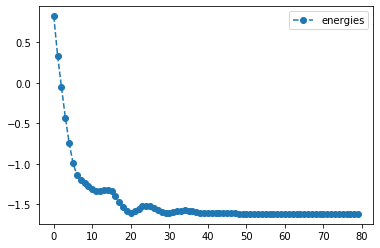

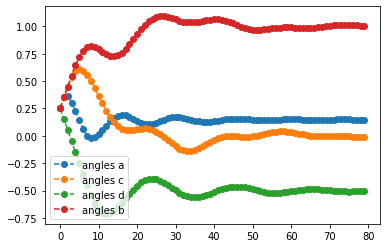

best energy:  -1.6179942172570136
optimal angles:  a : 0.14749682605178346
c : -0.0020942074899867142
d : -0.498209057390019
b : 1.0037044962376886



In [5]:
result.history.plot('energies')
result.history.plot('angles')
print('best energy: ',result.energy)
print('optimal angles: ',result.angles)

### We see that, minus a few hiccups, all the angles converge to optimimum values.
#### Excercise: is this truly the best performance possible, or are we stuck in a local minimum?

## Let's repeat what we did above, but with a few of the other methods! Here's RMSprop:

RMSprop optimization results:


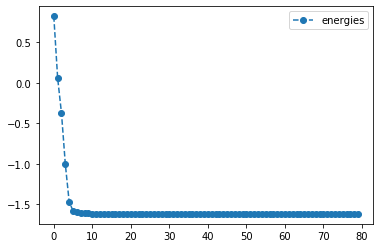

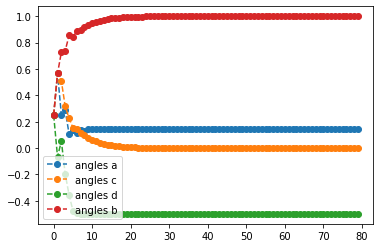

best energy:  -1.6180339887498905
optimal angles:  a : 0.14758363531643576
c : -1.625339216876925e-08
d : -0.5000000021961905
b : 1.0000000183809166



In [6]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}
lr=0.01
result=gd_min(O,lr=lr,
              method='rmsprop',
              maxiter=80,
              initial_values=init,
              silent=True)
print('RMSprop optimization results:')
result.history.plot('energies')
result.history.plot('angles')
print('best energy: ',result.energy)
print('optimal angles: ',result.angles)

## ... And here's Momentum:

momentum optimization results:


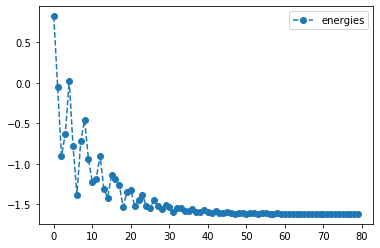

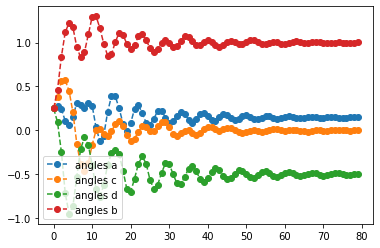

best energy:  -1.6178164176706864
optimal angles:  a : 0.153130292696303
c : -0.0008949959645234715
d : -0.5018114831041253
b : 0.9975386964199592



In [7]:
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}
lr=0.1
result=gd_min(O,lr=lr,
              method='momentum',
              maxiter=80,
              initial_values=init,
              silent=True)

print('momentum optimization results:')
result.history.plot('energies')
result.history.plot('angles')
print('best energy: ',result.energy)
print('optimal angles: ',result.angles)

## Note that when using the [RMSprop](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a) method, we reduced the learning rate from 0.1 to 0.01. Different methods may be more or less sensitive to choices of initial learning rate. Try going back to the previous examples, and choosing different learning rates, or different initial parameters, to gain a feel for how sensitive different methods are.

# 1.1: The GD optimizer, with the Quantum Natural Gradient.

### The Quantum Natural Gradient, or QNG, is a novel method of calculating gradients for quantum systems, inspired by the natural gradient sometimes employed in classical machine learning. The usual gradient we employ is with respect to a euclidean manifold, but this is not the only geometry -- nor even, the optimal geometry -- of quantum space. The QNG is, in essence, a method of taking gradients with respect to (an approximation to) the Fubini-Study metric. For information on how (and why) the QNG is used, see [Stokes et.al](https://arxiv.org/abs/1909.02108). 

### Using the qng in Tequila is as simple as passing in the keyword gradient='qng' to optimizers which support it, such as the GD optimizer.  We will use it to optimize a more complicated circuit below, and then compare the results to optimizing the same circuit with the regular gradient.

In [8]:
### this time, don't scale by pi

H = tq.paulis.Y(0)*tq.paulis.X(1)*tq.paulis.Y(2)
U = tq.gates.Ry(tq.numpy.pi/2,0) +tq.gates.Ry(tq.numpy.pi/3,1)+tq.gates.Ry(tq.numpy.pi/4,2)
U += tq.gates.Rz('a',0)+tq.gates.Rz('b',1)
U += tq.gates.CNOT(control=0,target=1)+tq.gates.CNOT(control=1,target=2)
U += tq.gates.Ry('c',1) +tq.gates.Rx('d',2)
U += tq.gates.CNOT(control=0,target=1)+tq.gates.CNOT(control=1,target=2)
E = tq.ExpectationValue(H=H, U=U)

print('drawing a more complicated circuit. Hope you like it!')
tq.draw(U)
### the keyword stop_count, below, stops optimization if no improvement occurs after 50 epochs.
### let's use a random initial starting point:
init={k:np.random.uniform(-2,2) for k in ['a','b','c','d']}

lr=0.01
result = tq.minimize(objective=E,
                     gradient='qng',
                     method='sgd', maxiter=200,lr=lr,
                     initial_values=init, silent=True)


drawing a more complicated circuit. Hope you like it!
0: ───Ry(0.5π)─────Rz(0.318309886183791*pi*f((a,))_0)───@────────────────────────────────────────────@───────
                                                        │                                            │
1: ───Ry(0.333π)───Rz(0.318309886183791*pi*f((b,))_1)───X───@───Ry(0.318309886183791*pi*f((c,))_2)───X───@───
                                                            │                                            │
2: ───Ry(0.25π)─────────────────────────────────────────────X───Rx(0.318309886183791*pi*f((d,))_3)───────X───


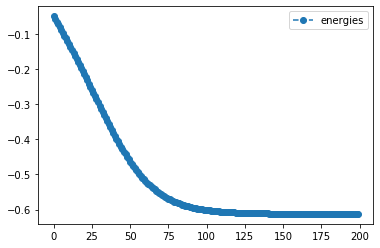

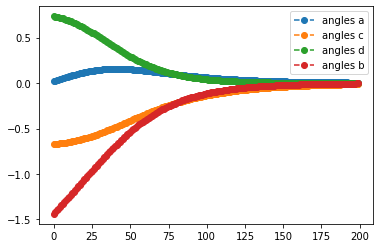

best energy with qng:  -0.612314712419902
optimal angles without qng:  a : 0.0055288327051460475
c : -0.01180277404169709
d : 0.00047237977948329067
b : -0.004297424659652667



In [9]:
result.history.plot('energies')
result.history.plot('angles')
print('best energy with qng: ',result.energy)
print('optimal angles without qng: ',result.angles)

## To gain appreciation for why one might use the QNG, let's optimize the same circuit with the same learning rate and the same method, but without QNG.

Optimizer: <class 'tequila.optimizers.optimizer_gd.OptimizerGD'> 
backend         : qulacs
backend_options : {}
samples         : None
save_history    : True
noise           : None

Objective       : 1 expectationvalues
Gradient        : 8 expectationvalues
active variables : 4
Iteration: 1 , Energy: -0.05072191, angles: {a: 0.01953691271451696, c: -0.6690097749305818, d: 0.7351163704563334, b: -1.4360747798959634}
Iteration: 2 , Energy: -0.05220953, angles: {a: 0.020997916584288918, c: -0.6686677976770256, d: 0.7347155076135351, b: -1.432544604210081}
Iteration: 3 , Energy: -0.05369801, angles: {a: 0.022456621949946725, c: -0.6683187187535617, d: 0.7343058430646016, b: -1.429014011291685}
Iteration: 4 , Energy: -0.05518730, angles: {a: 0.02391296190527662, c: -0.6679625396503065, d: 0.7338873842601134, b: -1.4254830076972864}
Iteration: 5 , Energy: -0.05667740, angles: {a: 0.025366869693076458, c: -0.6675992623044107, d: 0.7334601393584562, b: -1.42195159938735}
Iteration: 6 , Energy:

Iteration: 58 , Energy: -0.13686602, angles: {a: 0.09724321690706002, c: -0.6382774875385615, d: 0.6985508069266033, b: -1.2344450536052607}
Iteration: 59 , Energy: -0.13840160, angles: {a: 0.09847085264829385, c: -0.6375369926614615, d: 0.6976684649903726, b: -1.2309067234079265}
Iteration: 60 , Energy: -0.13993796, angles: {a: 0.09969265056160675, c: -0.636789707474217, d: 0.6967781988401365, b: -1.2273686602394007}
Iteration: 61 , Energy: -0.14147511, angles: {a: 0.10090855573621975, c: -0.6360356432272048, d: 0.6958800323922586, b: -1.2238308828751467}
Iteration: 62 , Energy: -0.14301307, angles: {a: 0.10211851430443512, c: -0.6352748107982726, d: 0.6949739894885969, b: -1.2202934115807436}
Iteration: 63 , Energy: -0.14455181, angles: {a: 0.10332247217503773, c: -0.6345072211397739, d: 0.6940600942690325, b: -1.216756265727701}
Iteration: 64 , Energy: -0.14609127, angles: {a: 0.10452037562934148, c: -0.6337328857256026, d: 0.6931383716185046, b: -1.213219465581598}
Iteration: 65 , 

Iteration: 118 , Energy: -0.23016605, angles: {a: 0.15890021448341599, c: -0.5823258094562143, d: 0.6325404941905687, b: -1.0234230550805947}
Iteration: 119 , Energy: -0.23173476, angles: {a: 0.15969557588306657, c: -0.5812061743510812, d: 0.6312348241974065, b: -1.0199451598207376}
Iteration: 120 , Energy: -0.23330362, angles: {a: 0.16048262958732834, c: -0.5800808897687048, d: 0.6299231776465127, b: -1.016469224957647}
Iteration: 121 , Energy: -0.23487262, angles: {a: 0.1612613514563202, c: -0.5789499847663492, d: 0.6286055961121271, b: -1.012995287446203}
Iteration: 122 , Energy: -0.23644170, angles: {a: 0.16203171824423065, c: -0.5778134878797382, d: 0.6272821214665124, b: -1.0095233848373315}
Iteration: 123 , Energy: -0.23801090, angles: {a: 0.16279370700327148, c: -0.5766714289111942, d: 0.6259527954329202, b: -1.0060535555760286}
Iteration: 124 , Energy: -0.23958015, angles: {a: 0.1635472955307125, c: -0.5755238372905105, d: 0.624617660777683, b: -1.002585837809267}
Iteration: 1

Iteration: 179 , Energy: -0.32526422, angles: {a: 0.19170956126732214, c: -0.5048999936206189, d: 0.5435899835694981, b: -0.8163379215876482}
Iteration: 180 , Energy: -0.32679474, angles: {a: 0.19197929277402742, c: -0.5035004101021138, d: 0.5420050859321308, b: -0.813056816426935}
Iteration: 181 , Energy: -0.32832361, angles: {a: 0.19224054481220826, c: -0.5020975346190777, d: 0.5404172028471184, b: -0.8097803616206072}
Iteration: 182 , Energy: -0.32985079, angles: {a: 0.192493337200409, c: -0.5006914147062149, d: 0.538826389895792, b: -0.8065086057464502}
Iteration: 183 , Energy: -0.33137626, angles: {a: 0.19273769074437602, c: -0.4992820980472412, d: 0.5372327028084946, b: -0.8032415964881799}
Iteration: 184 , Energy: -0.33289998, angles: {a: 0.1929736262126027, c: -0.49786963366697695, d: 0.5356361967195225, b: -0.7999793824235819}
Iteration: 185 , Energy: -0.33442190, angles: {a: 0.19320116564018114, c: -0.49645406954716115, d: 0.5340369281042766, b: -0.7967220124284647}
Iteration

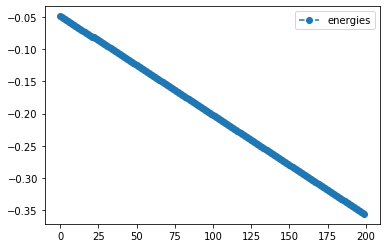

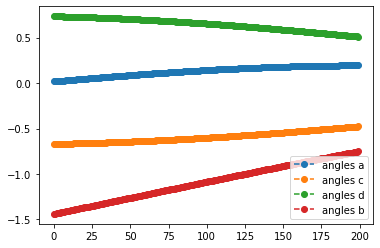

best energy without qng:  -0.3555172037387153
optimal angles without qng:  a : 0.19551897723545714
c : -0.47633839570711534
d : 0.5113885374237249
b : -0.7516544732133771



In [10]:
lr=0.01
result = tq.minimize(objective=E,
                     gradient=None,
                     method='sgd', maxiter=200,lr=lr,
                     initial_values=init, silent=False)
print('plotting what happens without QNG')
result.history.plot('energies')
result.history.plot('angles')
print('best energy without qng: ',result.energy)
print('optimal angles without qng: ',result.angles)

## Though the starting point was random (and so I, your humble tutorial writer, do not know what your graphs look like), you will most likely see that the QNG run achieved a greater degree of improvement, and that the trajectories followed by angles there was different from that followed by angles in the straight-gd optimization. Feel free to play around with other methods, learning rates, or circuits in the space below!


In [11]:
### have fun!

# 2. Bayesian Optimization

## [Bayesian optimization](https://arxiv.org/abs/1807.02811) is a method of global optimization, often used to tune hyperparameters in classical learning. It has also seen use in the optimization of [quantum circuits](https://arxiv.org/pdf/1812.08862.pdf). Tequila currently supports 2 different bayesian optimization algorithms: [Phoenics](https://github.com/aspuru-guzik-group/phoenics) and [GPyOpt](https://github.com/SheffieldML/GPyOpt), optimizers originally developed for optimizing expensive experimental procedures in chemistry. Click the links to get to the respective github pages, and download the optimizers before continuing this tutorial.

# 2.1: GPyOpt

## GPyOpt can be used like any of our other optimizers. Like the GD and SciPy optimizers, it also takes a 'method' keyword. 3 methods are supported: 'lbfgs','DIRECT', and 'CMA'. See the GPyOpt github for more info.

In [12]:
from tequila.optimizers.optimizer_gpyopt import minimize as gpy_min

## we will use GPyOpt to optimize the same circuits as seen above.

In [13]:
### optimizing the circuit in terms of pi makes the result of the optimization easier to interpret.

a = tq.Variable(name="a")*tq.numpy.pi
b = tq.Variable(name="b")*tq.numpy.pi
c = tq.Variable(name="c")*tq.numpy.pi
d = tq.Variable(name='d')*tq.numpy.pi

U = tq.gates.H(target=[0])
U += tq.gates.H(target=1)
U += tq.gates.Ry(target=0, angle=a)
U += tq.gates.Rz(target=1, angle=b)
U += tq.gates.Z(target=1,control=0)
U += tq.gates.Rx(target=0, angle=c)
U += tq.gates.Rx(target=1,angle=d)
U += tq.gates.Z(target=1,control=0)


### once we have a circuit, we pick a hamiltonian to optimize over
H=(tq.paulis.Y(0)+tq.paulis.Qm(0))*tq.paulis.X(1)
O=tq.ExpectationValue(U=U,H=H)

### we use the .draw function to pretty-print circuits via backend printers.
tq.draw(U,backend='qiskit')
print(O)

     ┌───┐┌───────────────┐   ┌───────────────┐   
q_0: ┤ H ├┤ Ry(f((a,))_0) ├─■─┤ Rx(f((c,))_2) ├─■─
     ├───┤├───────────────┤ │ ├───────────────┤ │ 
q_1: ┤ H ├┤ Rz(f((b,))_1) ├─■─┤ Rx(f((d,))_3) ├─■─
     └───┘└───────────────┘   └───────────────┘   
c_0: ═════════════════════════════════════════════
                                                  
c_1: ═════════════════════════════════════════════
                                                  
Objective with 1 unique expectation values
variables = [a, c, d, b]
types     = not compiled


Optimizer: <class 'tequila.optimizers.optimizer_gpyopt.OptimizerGpyOpt'> 
backend         : qulacs
backend_options : {}
samples         : None
save_history    : True
noise           : None

method          : lbfgs
Objective       : 1 expectationvalues
num acquisition: 1, time elapsed: 0.18s
num acquisition: 2, time elapsed: 0.50s
num acquisition: 3, time elapsed: 0.83s
num acquisition: 4, time elapsed: 1.85s
num acquisition: 5, time elapsed: 2.37s
num acquisition: 6, time elapsed: 2.75s
num acquisition: 7, time elapsed: 3.18s
num acquisition: 8, time elapsed: 3.66s
num acquisition: 9, time elapsed: 4.10s
num acquisition: 10, time elapsed: 4.57s
num acquisition: 11, time elapsed: 4.76s
num acquisition: 12, time elapsed: 5.00s
num acquisition: 13, time elapsed: 5.20s
num acquisition: 14, time elapsed: 5.39s
num acquisition: 15, time elapsed: 5.58s
num acquisition: 16, time elapsed: 5.75s
num acquisition: 17, time elapsed: 5.89s
num acquisition: 18, time elapsed: 6.20s
num acquisition: 19

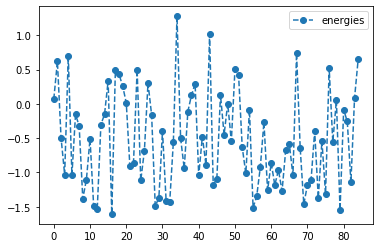

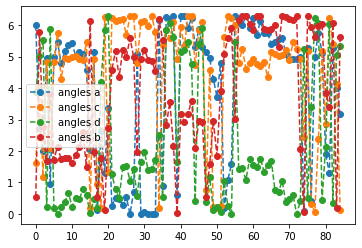

best energy:  -1.6045826795430622
optimal angles:  {a: 5.1334372720229595, c: 4.921374797087797, d: 0.46572885558529, b: 1.9648127105209245}


In [14]:
### let's use the lbfgs method.
init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}
### note: no lr is passed here! there are fewer tunable keywords for this optimizer.
result=gpy_min(O,
              method='lbfgs',
              maxiter=80,
              initial_values=init)

print('GPyOpt optimization results:')
result.history.plot('energies')
result.history.plot('angles')
print('best energy: ',result.energy)
print('optimal angles: ',result.angles)

## Perhaps you are looking at the plots above in horror. But, do take note: bayesian optimization is a global, exploratory optimization method, designed to explore large portions of parameter space while still seeking out optimality. Look at the optimal energy again, and one sees that the best performance of this optimization method matched that of all the gradient descent methods. We will apply gpyopt, next, to the QNG example circuit above, and see how bayesian optimization compares to QNG and SGD.

Hey, remember me?
0: ───Ry(0.5π)─────Rz(0.318309886183791*pi*f((a,))_0)───@────────────────────────────────────────────@───────
                                                        │                                            │
1: ───Ry(0.333π)───Rz(0.318309886183791*pi*f((b,))_1)───X───@───Ry(0.318309886183791*pi*f((c,))_2)───X───@───
                                                            │                                            │
2: ───Ry(0.25π)─────────────────────────────────────────────X───Rx(0.318309886183791*pi*f((d,))_3)───────X───
Optimizer: <class 'tequila.optimizers.optimizer_gpyopt.OptimizerGpyOpt'> 
backend         : qulacs
backend_options : {}
samples         : None
save_history    : True
noise           : None

method          : lbfgs
Objective       : 1 expectationvalues
num acquisition: 1, time elapsed: 0.30s
num acquisition: 2, time elapsed: 0.61s
num acquisition: 3, time elapsed: 0.98s
num acquisition: 4, time elapsed: 1.31s
num acquisition: 5, time elaps

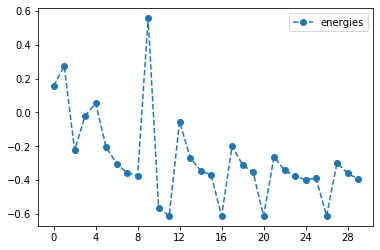

best energy:  -0.6123724356957851
optimal angles:  {a: 0.0, c: 0.0, d: 6.283185307179586, b: 0.0}


In [15]:
### this time, don't scale by pi

H = tq.paulis.Y(0)*tq.paulis.X(1)*tq.paulis.Y(2)
U = tq.gates.Ry(tq.numpy.pi/2,0) +tq.gates.Ry(tq.numpy.pi/3,1)+tq.gates.Ry(tq.numpy.pi/4,2)
U += tq.gates.Rz('a',0)+tq.gates.Rz('b',1)
U += tq.gates.CNOT(control=0,target=1)+tq.gates.CNOT(control=1,target=2)
U += tq.gates.Ry('c',1) +tq.gates.Rx('d',2)
U += tq.gates.CNOT(control=0,target=1)+tq.gates.CNOT(control=1,target=2)
E = tq.ExpectationValue(H=H, U=U)

print('Hey, remember me?')
tq.draw(U)
### the keyword stop_count, below, stops optimization if no improvement occurs after 50 epochs.
### let's use a random initial starting point:
init={k:np.random.uniform(-2,2) for k in ['a','b','c','d']}

result = gpy_min(objective=E,maxiter=25,method='lbfgs',
                     initial_values=init)

result.history.plot('energies')
print('best energy: ',result.energy)
print('optimal angles: ',result.angles)

## In a very, very small number of step, GPyOpt is able to match the performance of SGD with the QNG, and discovers the hidden truth: the optimil circuit, here, is one where all angles are zero (modulo 2 $\pi$)
## Feel free to play around more with other circuits in the space below!

# 2.2 Phoenics

## Finally, we turn to Phoenics. This algorithm, originally developed within the Aspuru-Guzik group (Hey, just like Tequila!), can be accessed in the usual fashion. It's performance on the two-qubit optimization circuit is shown below. Note that the number of datapoints exceeds the provided maxiter; maxiter here controls the number of parameter __batches__ suggested by phoenics. phoenics suggests a number of parameter sets to try out, per batch, that scales with the number of parameters (in a nonlinear fashion), so you may want to set maxiter lower if you are only playing around.

In [16]:
from tequila.optimizers.optimizer_phoenics import minimize as p_min

Phoenics config:

{'general': {'auto_desc_gen': 'False', 'batches': 5, 'boosted': 'False', 'parallel': 'False'}, 'parameters': [{'name': a, 'periodic': 'True', 'type': 'continuous', 'size': 1, 'low': 0, 'high': 6.283185307179586}, {'name': c, 'periodic': 'True', 'type': 'continuous', 'size': 1, 'low': 0, 'high': 6.283185307179586}, {'name': d, 'periodic': 'True', 'type': 'continuous', 'size': 1, 'low': 0, 'high': 6.283185307179586}, {'name': b, 'periodic': 'True', 'type': 'continuous', 'size': 1, 'low': 0, 'high': 6.283185307179586}], 'objectives': [{'name': 'Energy', 'goal': 'minimize'}]}
phoenics has recieved
objective: 

Objective with 1 unique expectation values
variables = [a, c, d, b]
types     = not compiled
noise model : None
samples     : None
maxiter     : 5
variables   : [a, c, d, b]
passive var : {}
backend options qulacs  {}
now lets begin
[TIME]:   0:00:00.000498   (overall)
***********************************************
energy = +0.74634539 , angles= {a: 6.2376809120178

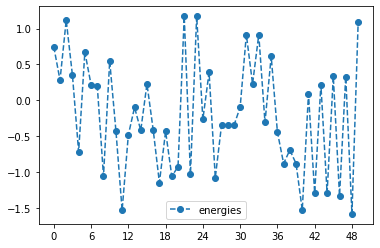

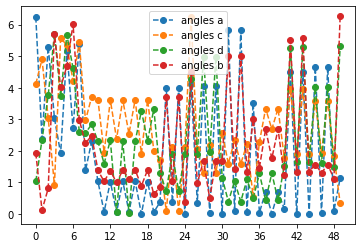

best energy:  -1.5855854069059063
optimal angles:  {a: 0.10323912650346756, c: 1.8350448608398438, d: 1.488460659980774, b: 1.115047574043274}


In [18]:
### optimizing the circuit in terms of pi makes the result of the optimization easier to interpret.

a = tq.Variable(name="a")*tq.numpy.pi
b = tq.Variable(name="b")*tq.numpy.pi
c = tq.Variable(name="c")*tq.numpy.pi
d = tq.Variable(name='d')*tq.numpy.pi

U = tq.gates.H(target=[0])
U += tq.gates.H(target=1)
U += tq.gates.Ry(target=0, angle=a)
U += tq.gates.Rz(target=1, angle=b)
U += tq.gates.Z(target=1,control=0)
U += tq.gates.Rx(target=0, angle=c)
U += tq.gates.Rx(target=1,angle=d)
U += tq.gates.Z(target=1,control=0)

H=(tq.paulis.Y(0)+tq.paulis.Qm(0))*tq.paulis.X(1)
O=tq.ExpectationValue(U=U,H=H)

init={'a':0.25,'b':0.25,'c':0.25,'d':0.25}
### geez! even fewer keywords! 
### to see what you can pass down to phoenics, see the tequila documentation for that module.
result=p_min(O,
            maxiter=5,
            initial_values=init,
            silent=False)

print('Phoenics optimization results on 2 qubit circuit:')
result.history.plot('energies')
result.history.plot('angles')
print('best energy: ',result.energy)
print('optimal angles: ',result.angles)

## This concludes our tutorial. Hope you had fun! Happy optimizing!